In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [5]:
block_size = 3 # context length: how many chars to take to predict the next
X, Y = [], []
for w in words[:5]:
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '---->', itos[ix])
    context = context[1:] + [ix] # crop and append

X =  torch.tensor(X)
Y = torch.tensor(Y)
X.shape, X.dtype

emma
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
... ----> a
..a ----> v
.av ----> a
ava ----> .
isabella
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


(torch.Size([32, 3]), torch.int64)

In [6]:
C =  torch.randn((27, 2)) # each 27 chars will have 2 dim space
C

tensor([[-0.5187, -0.6635],
        [-1.2788, -0.2109],
        [-1.3987, -1.0864],
        [ 0.3764, -0.2688],
        [ 0.1555,  0.9545],
        [ 0.9076, -1.2435],
        [ 0.6890,  0.0132],
        [-0.8300,  0.2763],
        [ 0.3329,  1.6711],
        [-0.0079, -0.6316],
        [-0.0263, -0.0091],
        [ 0.3656, -0.6223],
        [-1.5174,  0.9439],
        [-1.1339,  1.3864],
        [-0.7596,  2.5453],
        [-0.7795,  1.7824],
        [-0.1771,  1.4251],
        [-1.1884, -0.2153],
        [-0.0989, -1.0518],
        [-1.4279, -0.7732],
        [-0.2226, -0.2716],
        [ 0.8863,  2.0756],
        [ 0.4554,  1.6259],
        [-0.9193, -0.1384],
        [-1.4129, -0.8895],
        [-1.0657,  0.4222],
        [-1.7512,  0.1753]])

In [7]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C
# is equivalent to
C[5]

tensor([ 0.9076, -1.2435])

In [16]:
C.shape #27, 2
X.shape #32, 3
C[torch.tensor([5,5])] # you can index using tensor

tensor([[ 0.9076, -1.2435],
        [ 0.9076, -1.2435]])

In [18]:
# you can index using multi dim
# X[something, something] is integer between 0 to 26. (something, something) is used in place of row index of C(27, 2), forming (something, 3, 2). think of this like matrix of row=(something,3), col=2. (something, 3) designates 27 different characters. 2 is size of feature vector.
C[X].shape

torch.Size([32, 3, 2])

In [19]:
X[13,2]

tensor(1)

In [20]:
C[X][13, 2]

tensor([-1.2788, -0.2109])

In [21]:
C[1]

tensor([-1.2788, -0.2109])

In [24]:
emb = C[X]
W1 = torch.randn((6, 100)) # 6 = 3 (blocksize) * 2 (embedding dimention) # num of neuron is up to us, 100
b1 = torch.randn(100)
# want to do emb @ W1 + b1, but then emb has to be (32, 6)

In [29]:
emb[:, 0, :].shape # take the first(0) character for all 32 blocks and corresponding feature vector.

torch.Size([32, 2])

In [33]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape # concat by the second (1) dimention.
# the first 2 of 6 col is the feature vector for the first char in a block.
# the second 2 of 6 is the feature for the second in a block, and so is for third.

torch.Size([32, 6])

In [41]:
torch.unbind(torch.tensor([[1, 2, 3],
                           [4, 5, 6],
                           [7, 8, 9]]), 1) # unbind splits tensor by dimention 1 (col?)

(tensor([1, 4, 7]), tensor([2, 5, 8]), tensor([3, 6, 9]))

In [68]:
# emb:
# 
# [[][]] [[][]] [[][]]
# [[][]] [[][]] [[][]]
# ...    ...    ...
len(torch.unbind(emb, 1)) #3 #split tensor by col. form array of length 3, each element is (32, 2)
torch.tensor(torch.unbind(emb, 1)[0]).shape #(32, 2)
torch.cat(torch.unbind(emb, 1), 1).shape # (32, 6) same as the cell above*2

/tmp/ipykernel_723480/1562459235.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(torch.unbind(emb, 1)[0]).shape #(32, 2)


torch.Size([32, 6])

In [77]:
emb.view(32, 6) # much efficient

tensor([-0.5187, -0.6635])

In [83]:
h = emb.view(-1, 6) @ W1 + b1
h = torch.tanh(h)
h.shape

torch.Size([32, 100])

In [84]:
W2 = torch.randn(100, 27)
b2 = torch.randn(27)

In [87]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [89]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([32, 27])

In [91]:
prob[0].sum()

tensor(1.)

In [96]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(15.1159)

In [205]:
# -------------- now made respectable --------------
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [412]:
# split data
block_size = 5
def build_dataset(words):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182484, 5]) torch.Size([182484])
torch.Size([22869, 5]) torch.Size([22869])
torch.Size([22793, 5]) torch.Size([22793])


In [413]:
# init
featdim = 10
C  = torch.randn((27, featdim))
W1 = torch.randn((featdim*block_size, 300)) # 6 = 3 (blocksize) * 2 (embedding dimention) # num of neuron is up to us, 100
b1 = torch.randn(300)
W2 = torch.randn(300, 27)
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True
sum(p.nelement() for p in parameters)

23697

In [414]:
ix = torch.randint(0, Xtr.shape[0], (100,))

# forward pass
emb = C[Xtr[ix]] # C(27, featdim) #X(batch size, blocksize)
emb.shape

torch.Size([100, 5, 10])

2.379521608352661


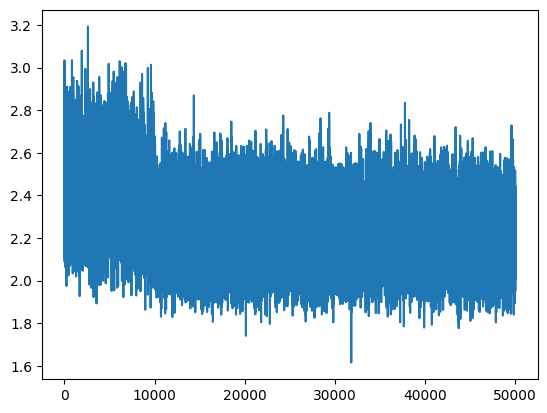

In [417]:
lossi = []
stepi = []
for i in range(50000):
  print(f"iteration: {i}", end="\r")
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (100,))
  
  # forward pass
  emb = C[Xtr[ix]] # C(27, featdim) #X(batch size, blocksize) # emb.shape = (batchsize, block_size, featdim)
  h = torch.tanh(emb.view(-1, featdim*block_size) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix]) # calculate loss much efficiently
  # print(loss.item())


  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 10000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  stepi.append(i)
  lossi.append(loss.item())
  
print(loss.item())
plt.plot(stepi, lossi)    

In [418]:
#using validation data
emb  =  C[Xdev]
h = torch.tanh(emb.view(-1, featdim*block_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2347, grad_fn=<NllLossBackward0>)

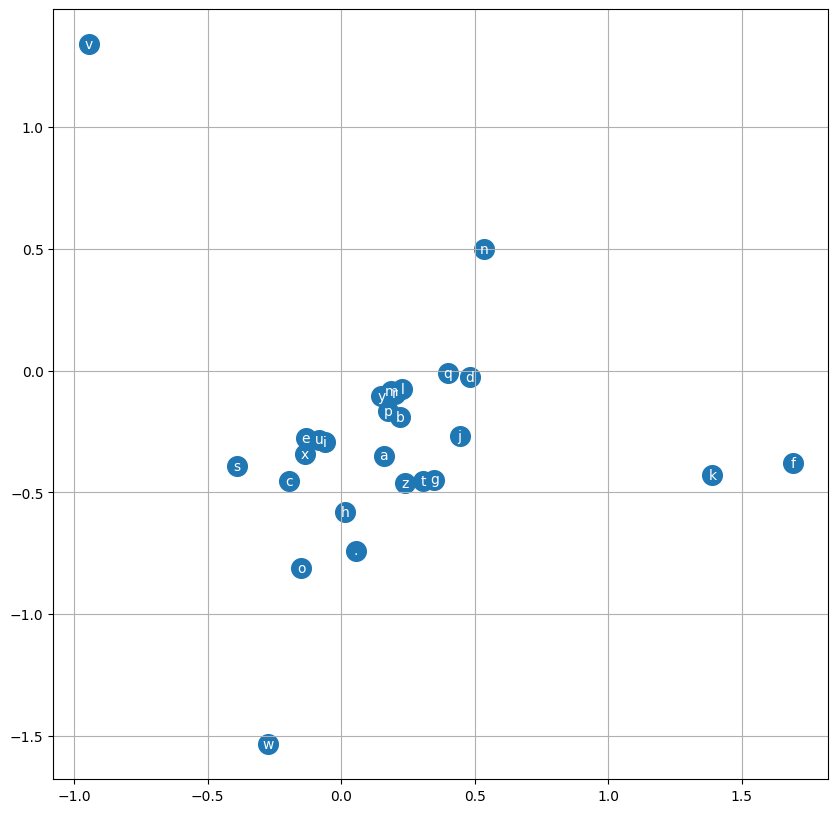

In [303]:
plt.figure(figsize=(10,10))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white", fontsize=10)
plt.grid("minor")  

In [378]:
C[torch.tensor([[0,0,0]])]


tensor([[[-0.5173,  1.0595, -0.7852,  0.4577, -0.4202,  1.0934,  0.4257,
          -1.5015, -0.0867, -0.3807],
         [-0.5173,  1.0595, -0.7852,  0.4577, -0.4202,  1.0934,  0.4257,
          -1.5015, -0.0867, -0.3807],
         [-0.5173,  1.0595, -0.7852,  0.4577, -0.4202,  1.0934,  0.4257,
          -1.5015, -0.0867, -0.3807]]], grad_fn=<IndexBackward0>)

In [407]:
torch.multinomial(torch.tensor([[0.1,0.7,0.2]]), num_samples=1)

tensor([[2]])

In [440]:
for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])] # torch.tensor([context]).shape is [1, block_size]. this is just X[ix] (batch_size, block_size). where batchsize is 1. #emb.shape is 1, blocksize, featdim
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2 # shape is [1, 27]
    probs = F.softmax(logits, dim=1) # shape is [1, 27]. passing [1, 27] is same as passing 27 in multinomial
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  
  print(''.join(itos[i] for i in out))
  

samiya.
sahith.
hiolie.
mobhiegh.
serh.
mansseel.
mary.
krimzie.
tam.
galianngh.
yanreni.
shysha.
ouigem.
lanaita.
june.
ramon.
lonx.
pranlis.
abyna.
baplee.
